In [2]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from utils_cells import get_images_list, transform_image, transform_target, resize_with_padding
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import torchvision.transforms.functional as F
import torch
from torchvision import transforms
from torchvision.transforms import functional as F
import cv2
from sklearn.model_selection import train_test_split
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torchmetrics import Precision, Recall
import numpy as np
import datetime
import random
import time
import torchvision.models as models

import random

class ImageDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None, reduce=False):
        self.transform = transform
        self.target_transform = target_transform
        self.dataset = shuffle(self.load_dataset())

    def load_dataset(self):
        path = []
        classes = []
        for image_class in os.listdir('cells_final'):
            for img in os.listdir(f'cells_final/{image_class}'):
                path.append(f'cells_final/{image_class}/{img}')
                classes.append(image_class)

        dataset_final = pd.DataFrame()
        dataset_final['path'] = path
        dataset_final['class'] = classes
        return dataset_final                
                          
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = cv2.imread(f'{self.dataset["path"].loc[idx]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_CUBIC)
        
        #image = resize_with_padding(image, (32, 32))
        image = image.astype(np.float32)
        image = image/255.0
        image = self.transform(image = image)['image'] if self.transform is not None else image

        target = self.dataset['class'].loc[idx]

        if target.strip() == 'normal':
            target_ = [1, 0, 0, 0]
        elif target.strip() == 'inflammatory':
            target_ = [0, 1, 0, 0]
        elif target.strip() == 'tumor':
            target_ = [0, 0, 1, 0]
        elif target.strip() == 'other':
            target_ = [0, 0, 0, 1]
        else:
            print(target)
        
        image = F.to_tensor(image)
        

        return image.float(), torch.Tensor(np.array(target_, dtype=np.float32))

/home/adam/miniconda3/envs/cells/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torch.nn as nn
from einops import rearrange

import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # [3, 32, 32] -> [16, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [16, 16, 16] -> [32, 8, 8]
            nn.ReLU(),
            nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),  # [32, 8, 8] -> [64, 4, 4]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 32) ,
        )



        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 256 * 4 * 4) , # Expand back to match the flattened input size
            nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),
            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [256, 4, 4] -> [64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64, 8, 8] -> [32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),   # [32, 16, 16] -> [3, 32, 32]
            nn.Sigmoid(),  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



# Example usage


model = ConvAutoencoder()

# Sample input
x = torch.randn(1, 3, 32, 32)
reconstructed_img = model(x)

print(reconstructed_img.shape)  # Should output torch.Size([1, 3, 32, 32])


torch.Size([1, 3, 32, 32])


In [4]:
model = model.to('cuda')

In [4]:
import time
import torch
import wandb
from torch.utils.data import DataLoader
import numpy as np

# Initialize WandB
run_name = f'conv_autoencoder_training_{datetime.datetime.now()}'

# Configuration
batch_size = 1024
learning_rate = 1e-3
num_epochs = 500
early_stop_patience = 20  # Number of epochs to wait for improvement
run_path = f'training_checkpoints/{run_name}'

# DataLoader
trainset = ImageDataset(data_path='train_data')
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

# Model, loss function, optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early Stopping
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    print('========================================')
    print(f'EPOCH: {epoch}')
    time_start = time.perf_counter()
    model.train()
    
    epoch_loss = 0
    for batch_idx, (inputs, _) in enumerate(trainloader):
        inputs = inputs.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Reconstruction loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(trainloader)
    print(f'Epoch {epoch} Average Loss: {avg_loss}')
    
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), f'{run_path}.pth')
        print(f'Saved new best model with loss {best_loss}')
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
    
    if patience_counter >= early_stop_patience:
        print(f'Early stopping at epoch {epoch} with best loss {best_loss}')
        break
    
    time_epoch = time.perf_counter() - time_start
    print(f'Epoch {epoch} time: {time_epoch/60} minutes')
    print('--------------------------------')

# Load the best model state dict
print(f'Loading model from {run_path}.pth')
model.load_state_dict(torch.load(f'{run_path}.pth'))

EPOCH: 0
Epoch 0 Average Loss: 0.011213057869645727
Saved new best model with loss 0.011213057869645727
Epoch 0 time: 0.10881250073333225 minutes
--------------------------------
EPOCH: 1
Epoch 1 Average Loss: 0.003440995963456312
Saved new best model with loss 0.003440995963456312
Epoch 1 time: 0.10806446025000392 minutes
--------------------------------
EPOCH: 2
Epoch 2 Average Loss: 0.0025446369826006812
Saved new best model with loss 0.0025446369826006812
Epoch 2 time: 0.10787670719999672 minutes
--------------------------------
EPOCH: 3
Epoch 3 Average Loss: 0.0023465674246043555
Saved new best model with loss 0.0023465674246043555
Epoch 3 time: 0.10774931626666936 minutes
--------------------------------
EPOCH: 4
Epoch 4 Average Loss: 0.0022813760569448224
Saved new best model with loss 0.0022813760569448224
Epoch 4 time: 0.10781647945000258 minutes
--------------------------------
EPOCH: 5
Epoch 5 Average Loss: 0.0022560124363897754
Saved new best model with loss 0.0022560124363

<All keys matched successfully>

In [5]:
model.load_state_dict(torch.load(f'training_checkpoints/conv_autoencoder_training_2024-08-22 18:43:28.462169.pth'))
features = []
classes = []
paths = []
model.eval()
trainset = ImageDataset(data_path='train_data')
torch.multiprocessing.set_sharing_strategy('file_system')
model = model.to('cuda')
with torch.no_grad():
    for idx in range(0, len(trainset)-1):
        img, cls = trainset[idx]
        classes.append(np.argmax(cls.cpu().detach().numpy()))
        img = img.unsqueeze(0).to('cuda')
        feature = model.encoder(img)
        features.append(feature.cpu().detach().numpy())


    


In [6]:
len(features[1][0])

32

In [7]:
features = [feature[0] for feature in features]

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
arr = np.array(features)
arr = MinMaxScaler().fit_transform(np.array(arr))

In [9]:
df = pd.DataFrame()

In [10]:
import numpy as np



In [53]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_embs = pca.fit_transform(np.array(arr))

# Add to dataframe for convenience
df['pca_x'] = pca_embs[:, 0]
df['pca_y'] = pca_embs[:, 1]


In [54]:
import umap.umap_ as umap

# Perform UMAP
umap_reducer = umap.UMAP(n_components=2, metric="euclidean", n_jobs=-1, min_dist=0.00001, n_neighbors=100)
umap_embs = umap_reducer.fit_transform(arr)

# Add to dataframe for convenience
df['umap_x'] = umap_embs[:, 0]
df['umap_y'] = umap_embs[:, 1]


/tmp/ipykernel_78806/825490659.py:10: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(ax=axes[0], x='pca_x', y='pca_y', hue='class', data=df, palette=palette, alpha=0.1, legend=False)
/tmp/ipykernel_78806/825490659.py:16: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(ax=axes[1], x='umap_x', y='umap_y', hue='class', data=df, palette=palette, alpha=0.1, legend=False)


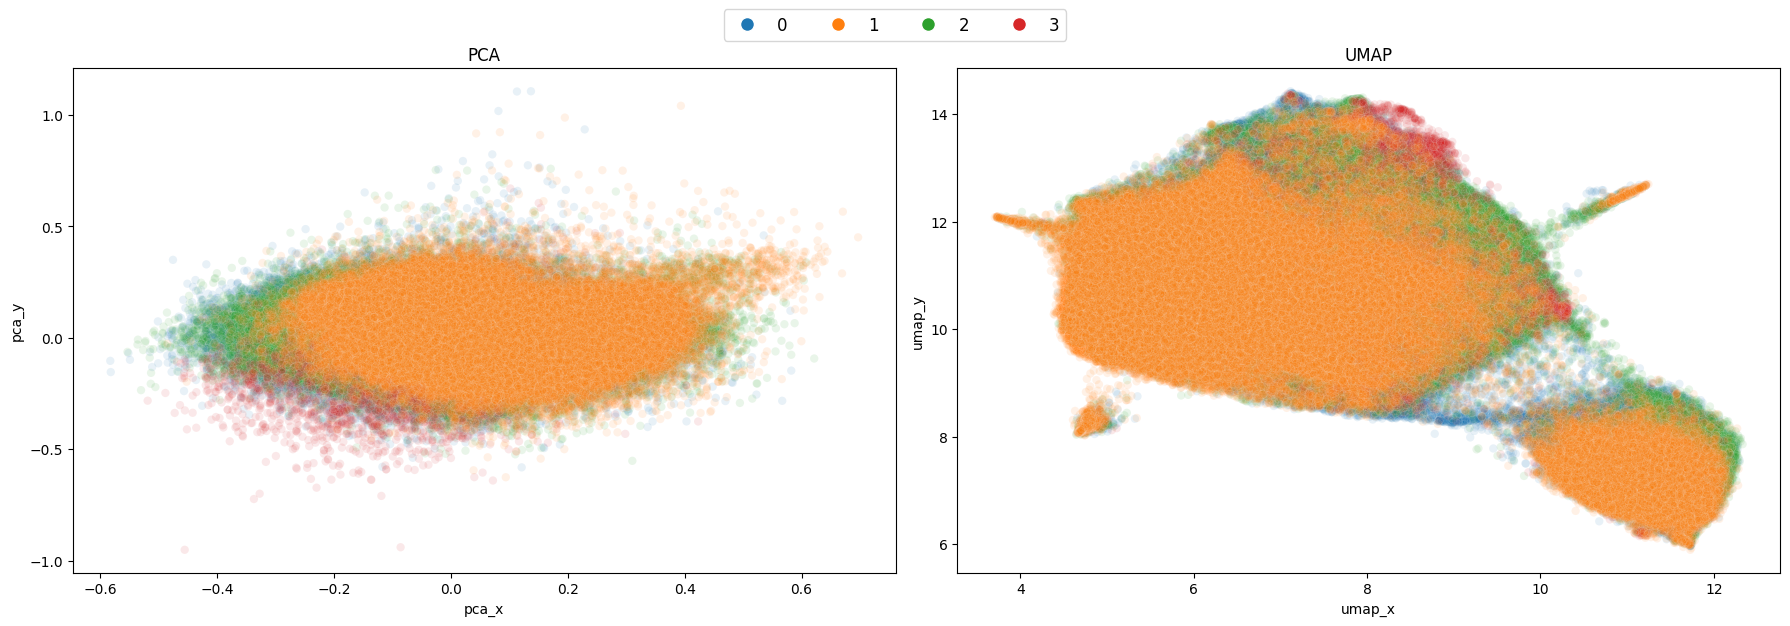

In [58]:
FS = (18, 6)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=FS)

# Set up the Seaborn color palette
palette = sns.color_palette('tab10')

# PCA plot
sns.scatterplot(ax=axes[0], x='pca_x', y='pca_y', hue='class', data=df, palette=palette, alpha=0.1, legend=False)
axes[0].set_title('PCA')
axes[0].set_xlabel('pca_x')
axes[0].set_ylabel('pca_y')

# UMAP plot
sns.scatterplot(ax=axes[1], x='umap_x', y='umap_y', hue='class', data=df, palette=palette, alpha=0.1, legend=False)
axes[1].set_title('UMAP')
axes[1].set_xlabel('umap_x')
axes[1].set_ylabel('umap_y')

# Create a custom legend
# Extract the unique classes and their colors
unique_classes = sorted(df['class'].unique())
handles = []
for cls in unique_classes:
    color = palette[unique_classes.index(cls)]
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cls)
    handles.append(handle)

# Add the custom legend to the figure
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.15, 1))

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot


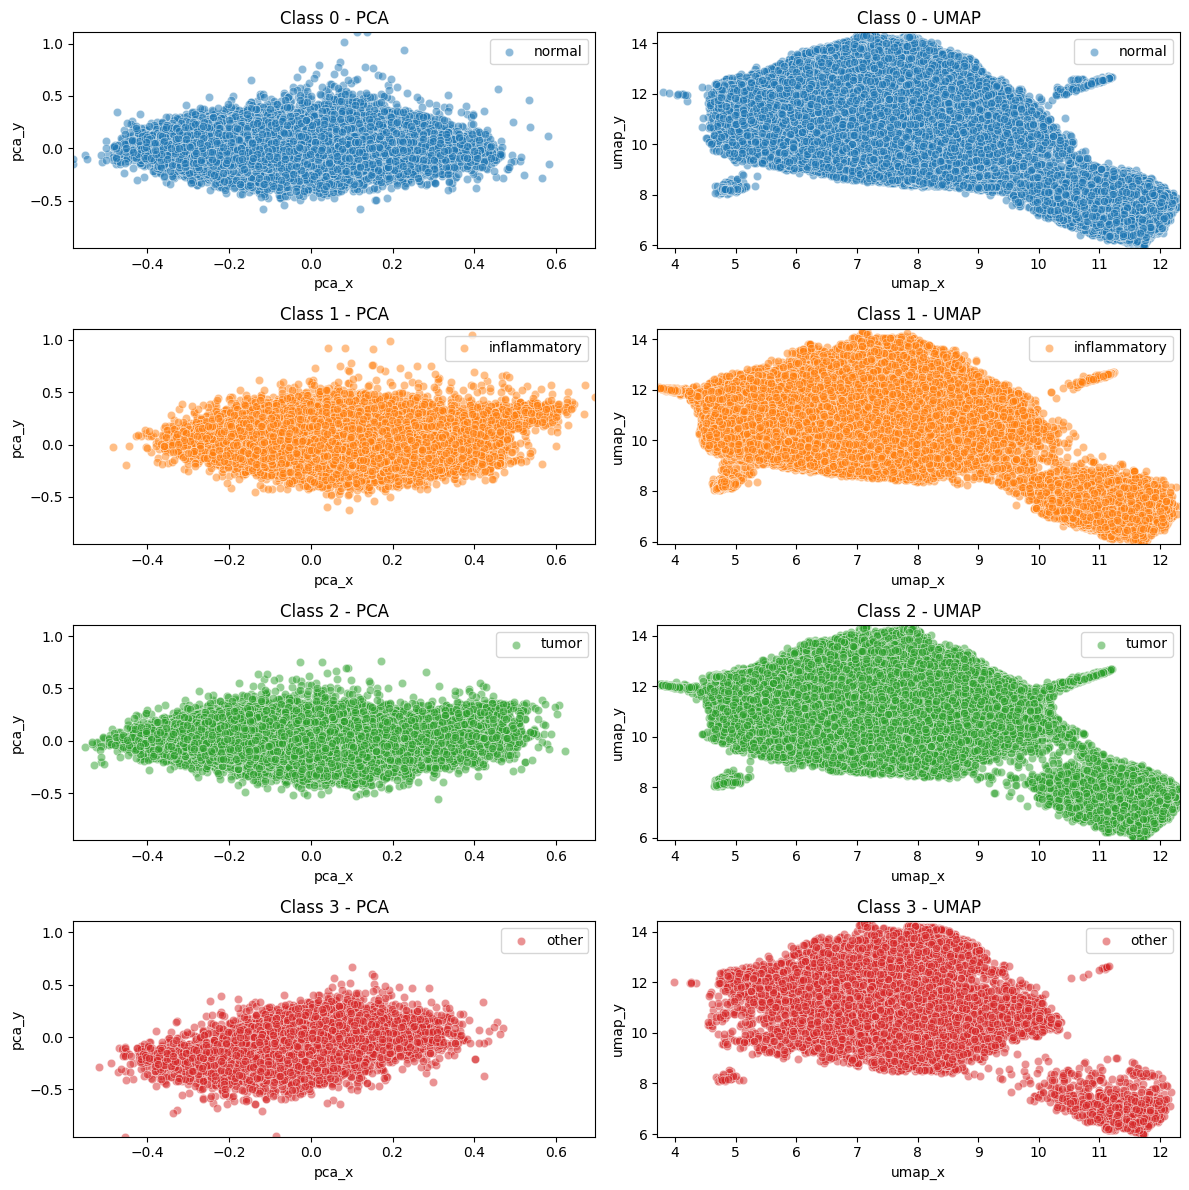

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the Seaborn color palette
palette = sns.color_palette('tab10')
names =  ['normal', 'inflammatory', 'tumor', 'other']

# Get the unique classes
unique_classes = sorted(df['class'].unique())

# Create a figure with 8 subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# Loop over the unique classes
for i, cls in enumerate(unique_classes):
    # Get the current axis for PCA
    ax_pca = axes[i, 0]
    
    # Get the current axis for UMAP
    ax_umap = axes[i, 1]
    
    # Filter the data for the current class
    class_df = df[df['class'] == cls]
    
    # PCA plot
    sns.scatterplot(ax=ax_pca, x='pca_x', y='pca_y', data=class_df, color=palette[i], alpha=0.5, label=names[i])
    ax_pca.set_title(f'Class {cls} - PCA')
    ax_pca.set_xlabel('pca_x')
    ax_pca.set_ylabel('pca_y')
    
    # Set the x-axis and y-axis limits to be the same for all PCA plots
    ax_pca.set_xlim(df['pca_x'].min(), df['pca_x'].max())
    ax_pca.set_ylim(df['pca_y'].min(), df['pca_y'].max())
    
    # UMAP plot
    sns.scatterplot(ax=ax_umap, x='umap_x', y='umap_y', data=class_df, color=palette[i], alpha=0.5, label=names[i])
    ax_umap.set_title(f'Class {cls} - UMAP')
    ax_umap.set_xlabel('umap_x')
    ax_umap.set_ylabel('umap_y')
    
    # Set the x-axis and y-axis limits to be the same for all UMAP plots
    ax_umap.set_xlim(df['umap_x'].min(), df['umap_x'].max())
    ax_umap.set_ylim(df['umap_y'].min(), df['umap_y'].max())

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_78806/3846157492.py:10: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(ax=axes[0], x='pca_x', y='pca_y', hue='class', data=df, palette=palette, alpha=0.6, legend=False)
/tmp/ipykernel_78806/3846157492.py:16: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(ax=axes[1], x='umap_x', y='umap_y', hue='class', data=df, palette=palette, alpha=0.6, legend=False)


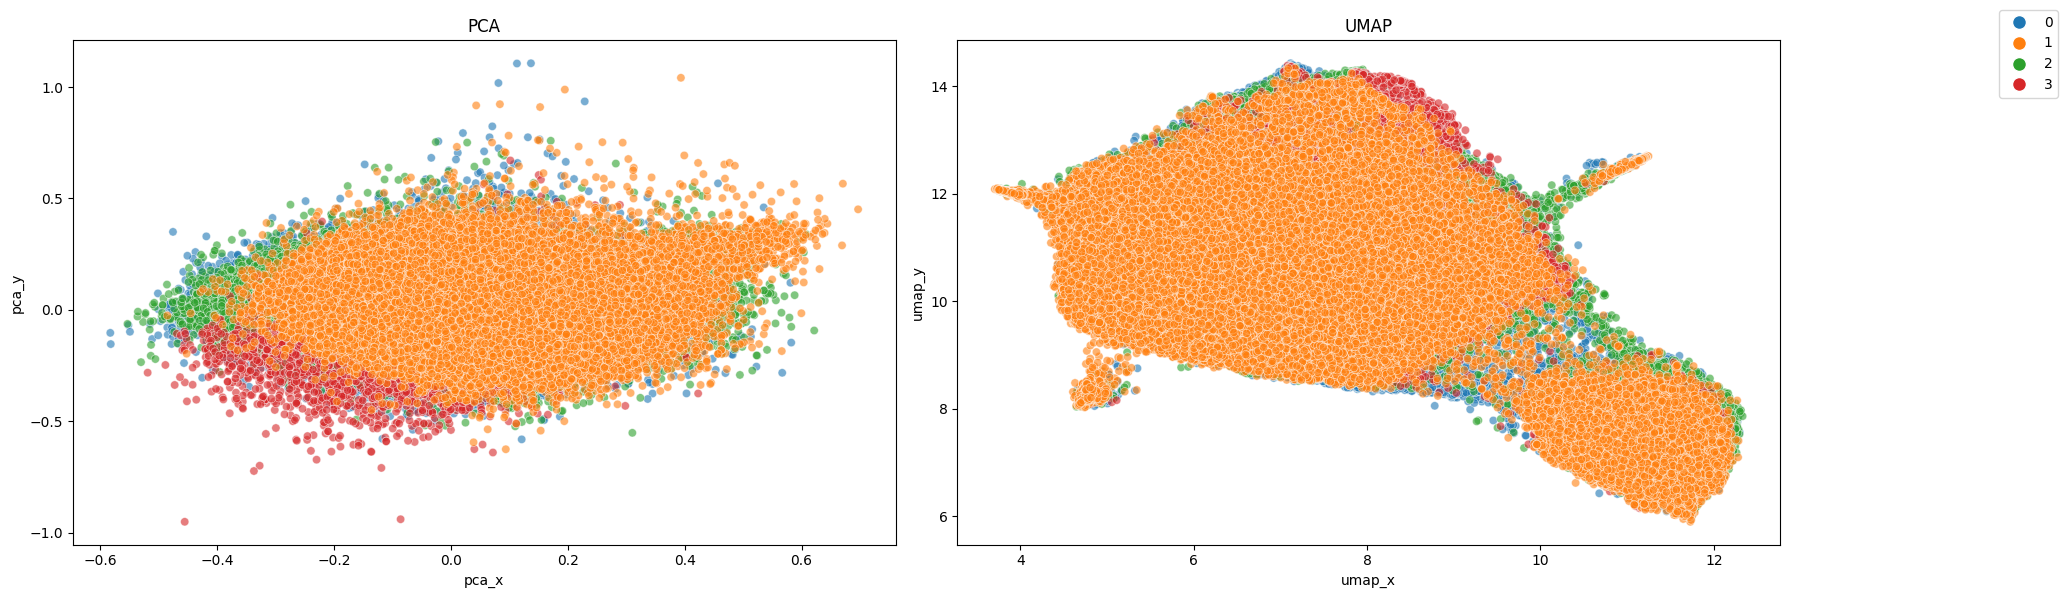

In [57]:
FS = (18, 6)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=FS)

# Set up the Seaborn color palette
palette = sns.color_palette('tab10')

# PCA plot
sns.scatterplot(ax=axes[0], x='pca_x', y='pca_y', hue='class', data=df, palette=palette, alpha=0.6, legend=False)
axes[0].set_title('PCA')
axes[0].set_xlabel('pca_x')
axes[0].set_ylabel('pca_y')

# UMAP plot
sns.scatterplot(ax=axes[1], x='umap_x', y='umap_y', hue='class', data=df, palette=palette, alpha=0.6, legend=False)
axes[1].set_title('UMAP')
axes[1].set_xlabel('umap_x')
axes[1].set_ylabel('umap_y')

# Create a custom legend
# Extract the unique classes and their colors
unique_classes = sorted(df['class'].unique())
handles = []
for cls in unique_classes:
    color = palette[unique_classes.index(cls)]
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cls)
    handles.append(handle)

# Add the custom legend to the figure
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.15, 1))

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

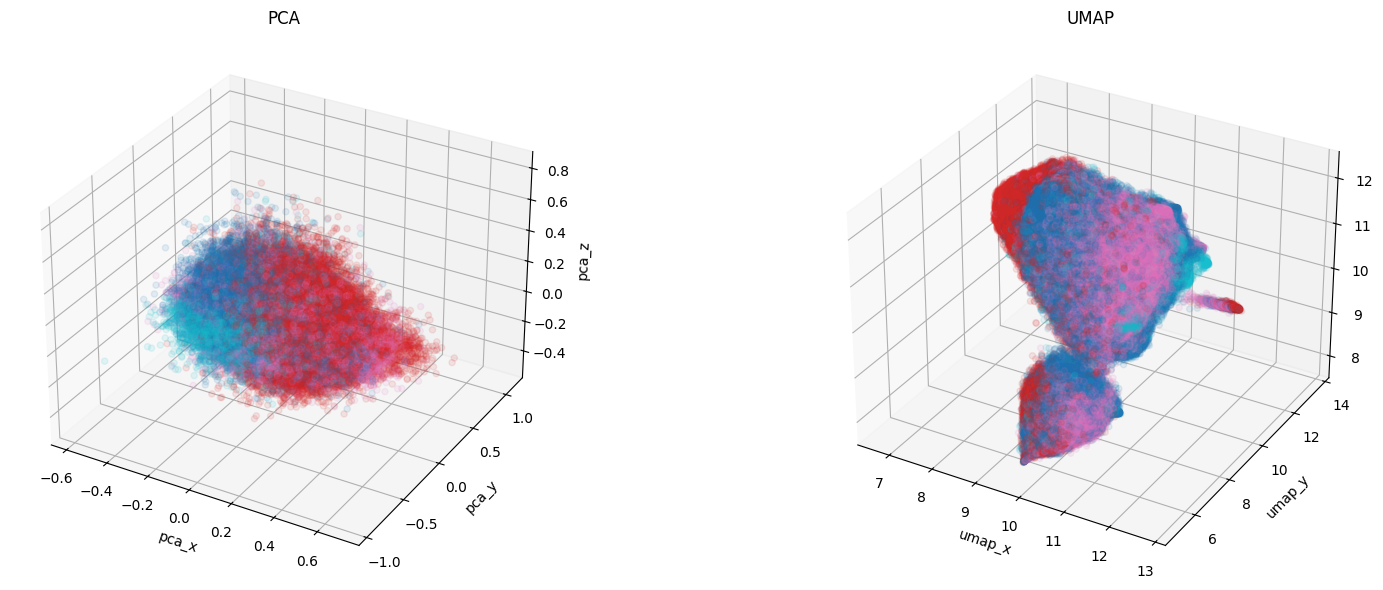

In [14]:
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting toolkit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'arr' and 'classes' are defined somewhere earlier in the code
# and the dataframes 'df' is also available

# Perform PCA
pca = PCA(n_components=3)
pca_embs = pca.fit_transform(np.array(arr))

# Add to dataframe for convenience
df['pca_x'] = pca_embs[:, 0]
df['pca_y'] = pca_embs[:, 1]
df['pca_z'] = pca_embs[:, 2]  # Adding z-axis

# Perform UMAP
umap_reducer = umap.UMAP(n_components=3, metric="euclidean", n_jobs=-1, min_dist=0.0001, n_neighbors=100)
umap_embs = umap_reducer.fit_transform(arr)

# Add to dataframe for convenience
df['umap_x'] = umap_embs[:, 0]
df['umap_y'] = umap_embs[:, 1]
df['umap_z'] = umap_embs[:, 2]  # Adding z-axis

df['class'] = classes

# Define figure size and number of subplots
FS = (18, 6)

# Create subplots
fig = plt.figure(figsize=FS)

# PCA 3D plot
ax_pca = fig.add_subplot(121, projection='3d')
sc_pca = ax_pca.scatter(df['pca_x'], df['pca_y'], df['pca_z'], c=df['class'], cmap='tab10', alpha=0.1)
ax_pca.set_title('PCA')
ax_pca.set_xlabel('pca_x')
ax_pca.set_ylabel('pca_y')
ax_pca.set_zlabel('pca_z')

# UMAP 3D plot
ax_umap = fig.add_subplot(122, projection='3d')
sc_umap = ax_umap.scatter(df['umap_x'], df['umap_y'], df['umap_z'], c=df['class'], cmap='tab10', alpha=0.1)
ax_umap.set_title('UMAP')
ax_umap.set_xlabel('umap_x')
ax_umap.set_ylabel('umap_y')
ax_umap.set_zlabel('umap_z')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


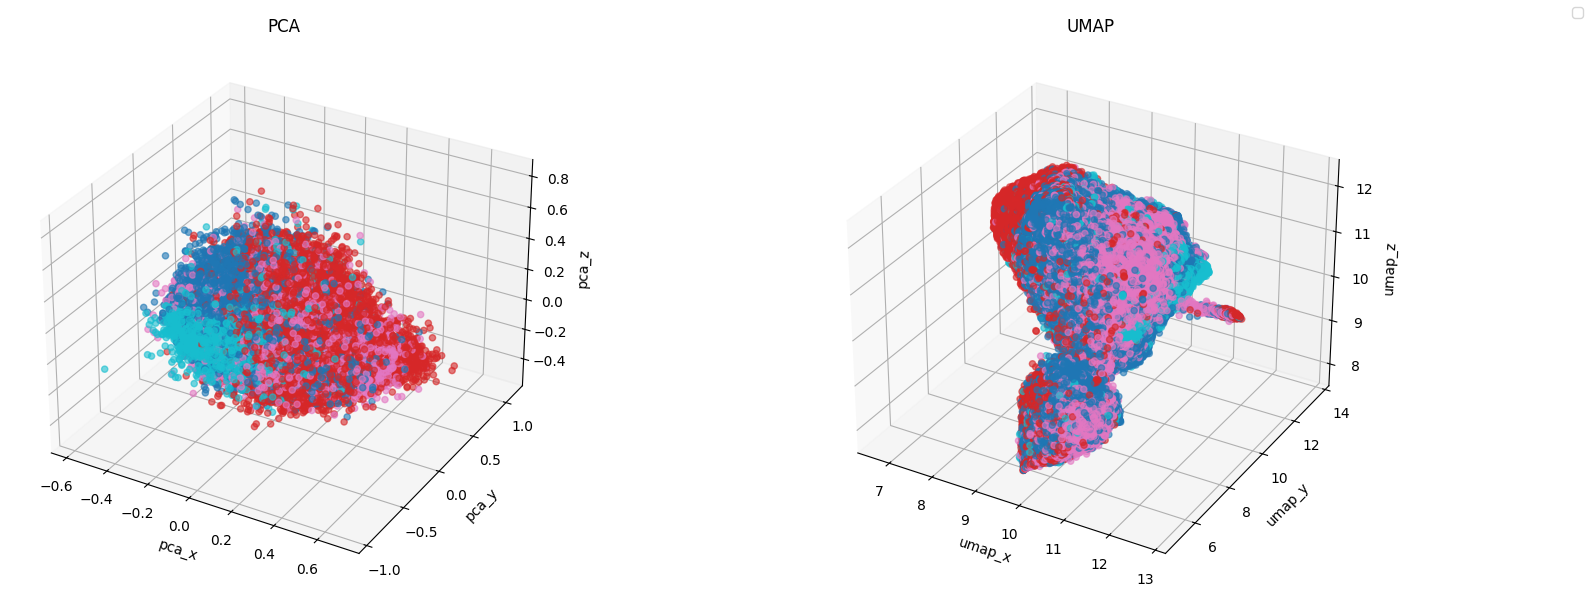

In [42]:
df['class'] = classes

# Define figure size and number of subplots
FS = (18, 6)


# Create subplots
fig = plt.figure(figsize=FS)

# PCA 3D plot
ax_pca = fig.add_subplot(121, projection='3d')
sc_pca = ax_pca.scatter(df['pca_x'], df['pca_y'], df['pca_z'], c=df['class'], cmap='tab10', alpha=0.6)
ax_pca.set_title('PCA')
ax_pca.set_xlabel('pca_x')
ax_pca.set_ylabel('pca_y')
ax_pca.set_zlabel('pca_z')

# UMAP 3D plot
ax_umap = fig.add_subplot(122, projection='3d')
sc_umap = ax_umap.scatter(df['umap_x'], df['umap_y'], df['umap_z'], c=df['class'], cmap='tab10', alpha=0.6)
ax_umap.set_title('UMAP')
ax_umap.set_xlabel('umap_x')
ax_umap.set_ylabel('umap_y')
ax_umap.set_zlabel('umap_z')

# Create custom legend
fig.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


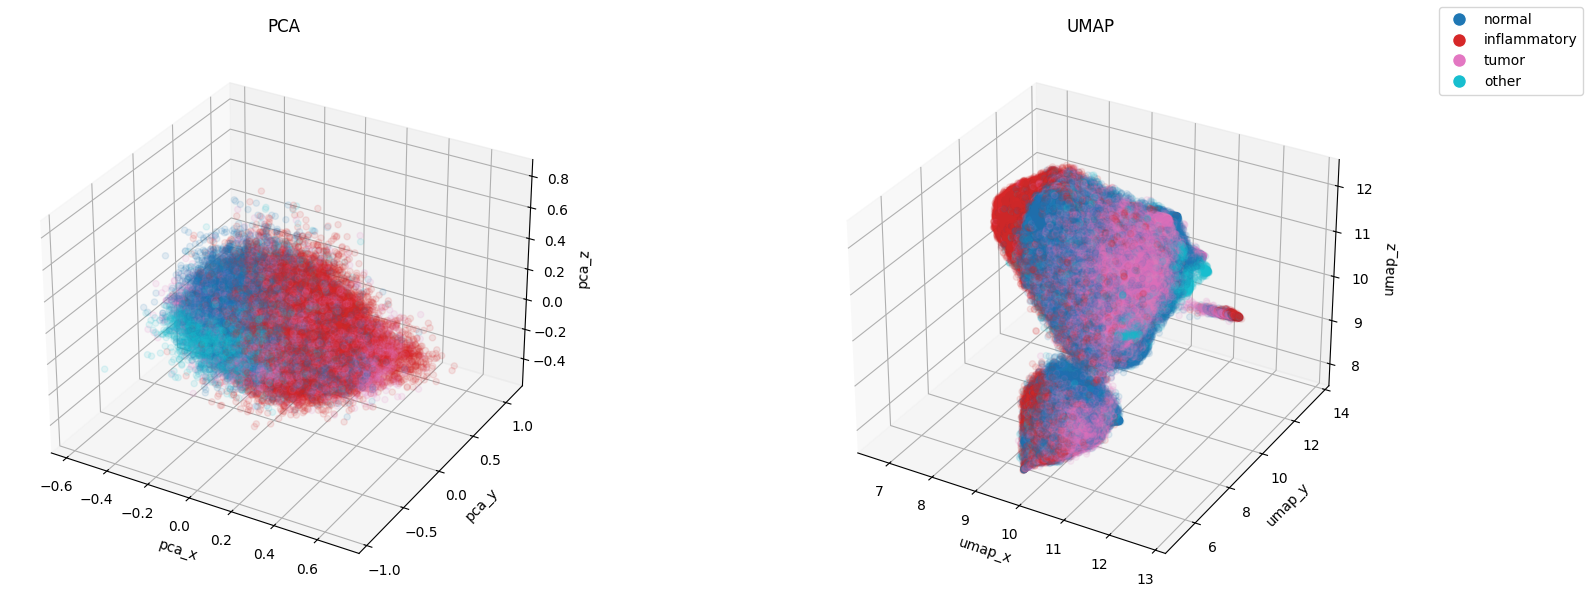

In [50]:
class_names = ['normal', 'inflammatory', 'tumor', 'other']
num_classes = len(class_names)

# Define figure size and number of subplots
FS = (18, 6)

# Create subplots
fig = plt.figure(figsize=FS)

# PCA 3D plot
ax_pca = fig.add_subplot(121, projection='3d')
scatter_pca = ax_pca.scatter(df['pca_x'], df['pca_y'], df['pca_z'], c=df['class'], cmap='tab10', alpha=0.1)
ax_pca.set_title('PCA')
ax_pca.set_xlabel('pca_x')
ax_pca.set_ylabel('pca_y')
ax_pca.set_zlabel('pca_z')

# UMAP 3D plot
ax_umap = fig.add_subplot(122, projection='3d')
scatter_umap = ax_umap.scatter(df['umap_x'], df['umap_y'], df['umap_z'], c=df['class'], cmap='tab10', alpha=0.1)
ax_umap.set_title('UMAP')
ax_umap.set_xlabel('umap_x')
ax_umap.set_ylabel('umap_y')
ax_umap.set_zlabel('umap_z')

# Extract the colormap
cmap = plt.get_cmap('tab10')
norm = plt.Normalize(vmin=0, vmax=num_classes - 1)

# Create legend handles with the exact colors used in the scatter plots
handles = []
for i, class_name in enumerate(class_names):
    color = cmap(norm(i))
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=class_name)
    handles.append(handle)

# Create a legend with the custom handles
fig.legend(handles=handles, loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

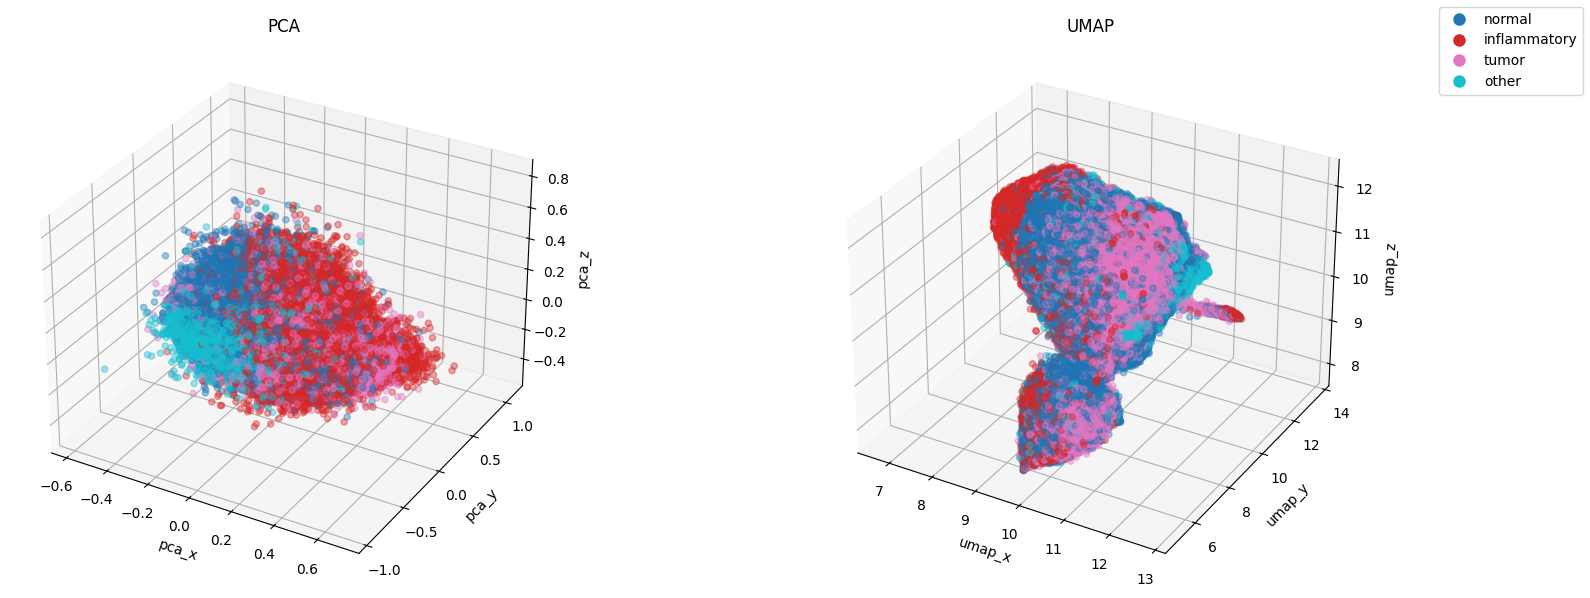

In [51]:
class_names = ['normal', 'inflammatory', 'tumor', 'other']
num_classes = len(class_names)

# Define figure size and number of subplots
FS = (18, 6)

# Create subplots
fig = plt.figure(figsize=FS)

# PCA 3D plot
ax_pca = fig.add_subplot(121, projection='3d')
scatter_pca = ax_pca.scatter(df['pca_x'], df['pca_y'], df['pca_z'], c=df['class'], cmap='tab10', alpha=0.4)
ax_pca.set_title('PCA')
ax_pca.set_xlabel('pca_x')
ax_pca.set_ylabel('pca_y')
ax_pca.set_zlabel('pca_z')

# UMAP 3D plot
ax_umap = fig.add_subplot(122, projection='3d')
scatter_umap = ax_umap.scatter(df['umap_x'], df['umap_y'], df['umap_z'], c=df['class'], cmap='tab10', alpha=0.4)
ax_umap.set_title('UMAP')
ax_umap.set_xlabel('umap_x')
ax_umap.set_ylabel('umap_y')
ax_umap.set_zlabel('umap_z')

# Extract the colormap
cmap = plt.get_cmap('tab10')
norm = plt.Normalize(vmin=0, vmax=num_classes - 1)

# Create legend handles with the exact colors used in the scatter plots
handles = []
for i, class_name in enumerate(class_names):
    color = cmap(norm(i))
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=class_name)
    handles.append(handle)

# Create a legend with the custom handles
fig.legend(handles=handles, loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_classif

# Assuming 'arr' is your feature array and 'classes' is your target array
# Convert to DataFrame for easier manipulation
df_features = pd.DataFrame(arr)
df_features['class'] = classes

# Separate features and target
X = df_features.drop(columns=['class'])  # Features
y = df_features['class']  # Target (classes)

# Perform ANOVA to get F-statistic and p-values
F_values, p_values = f_classif(X, y)

# Create a DataFrame to hold feature importance scores
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F_value': F_values,
    'p_value': p_values
})

# Sort features by F_value in descending order
feature_importance = feature_importance.sort_values(by='F_value', ascending=False)

# Extract the two most differentiating features
top_2_features = feature_importance['Feature'].head(2).values

# Output the most differentiating features
print("The two most differentiating features are:", top_2_features)

# Optional: Filter the original data to include only the top 2 features
X_top2 = X[top_2_features]


The two most differentiating features are: [22 4]


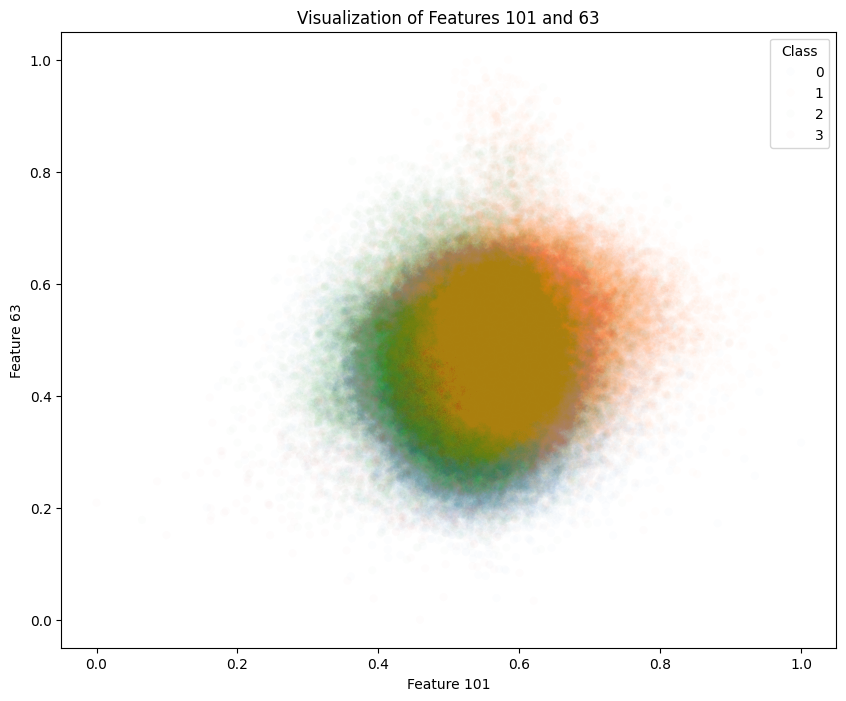

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'arr' is your feature array and 'classes' is your target array

# Extract the two most differentiating features
feature_1 = arr[:, 22]
feature_2 = arr[:, 4]

# Create a DataFrame for visualization
df_viz = pd.DataFrame({
    'feature_101': feature_1,
    'feature_63': feature_2,
    'class': classes
})

# Plot the scatter plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='feature_101', y='feature_63', hue='class', data=df_viz, palette='tab10', alpha=0.01)
plt.title('Visualization of Features 101 and 63')
plt.xlabel('Feature 101')
plt.ylabel('Feature 63')
plt.legend(title='Class', loc='upper right')

# Show the plot
plt.show()


In [19]:
import numpy as np
import pandas as pd
from scipy.stats import kruskal

# Assuming 'arr' is your feature array and 'classes' is your target array
# Convert to DataFrame for easier manipulation
df_features = pd.DataFrame(arr)
df_features['class'] = classes

# Separate features and target
X = df_features.drop(columns=['class'])  # Features
y = df_features['class']  # Target (classes)

# Initialize a list to hold the results
kruskal_results = []

# Perform Kruskal-Wallis test for each feature
for column in X.columns:
    stat, p_value = kruskal(*[X[column][y == cls] for cls in np.unique(y)])
    kruskal_results.append((column, stat, p_value))

# Convert results to DataFrame for easier analysis
kruskal_df = pd.DataFrame(kruskal_results, columns=['Feature', 'H_stat', 'p_value'])

# Sort features by H_stat in descending order (larger H_stat indicates more differentiation)
kruskal_df = kruskal_df.sort_values(by='H_stat', ascending=False)

# Extract the two most differentiating features
top_2_features = kruskal_df['Feature'].head(2).values

# Output the most differentiating features
print("The two most differentiating features are:", top_2_features)

# Optional: Filter the original data to include only the top 2 features
X_top2 = X[top_2_features]


The two most differentiating features are: [22  4]


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu

# Assuming arr and df are already defined, containing the data and labels respectively
# df['class'] contains the class labels
df['class'] = classes
# Number of classes
num_classes = len(np.unique(df['class']))

# Perform PCA and reduce to 1 component
pca_one_component = PCA(n_components=1)
pca_one_comp_embs = pca_one_component.fit_transform(arr)

# Perform UMAP and reduce to 1 component
umap_one_component = umap.UMAP(n_components=1, metric="euclidean", n_jobs=-1, min_dist=0.00001, n_neighbors=100)
umap_one_comp_embs = umap_one_component.fit_transform(arr)



   Class  PCA_Lilliefors_Statistic  PCA_Lilliefors_PValue  \
0      0                  0.018288                  0.001   
1      1                  0.017155                  0.001   
2      2                  0.045065                  0.001   
3      3                  0.032319                  0.001   

   UMAP_Lilliefors_Statistic  UMAP_Lilliefors_PValue  
0                   0.067748                   0.001  
1                   0.218979                   0.001  
2                   0.082488                   0.001  
3                   0.070771                   0.001  


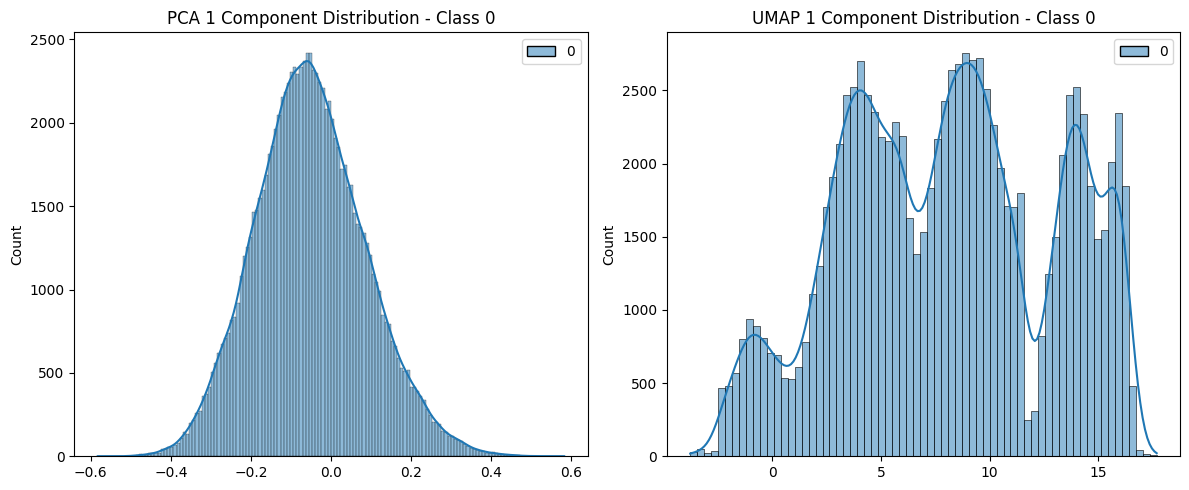

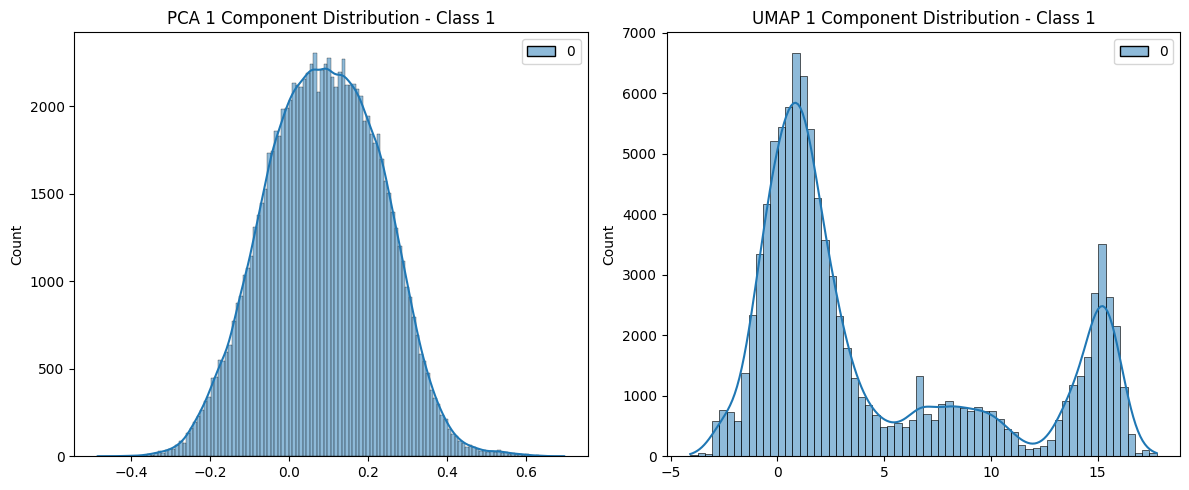

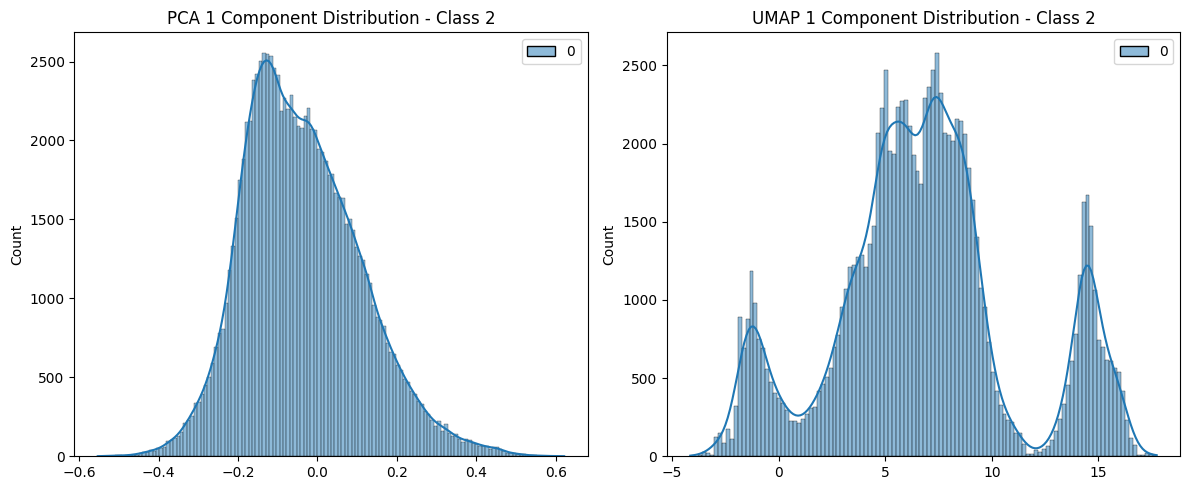

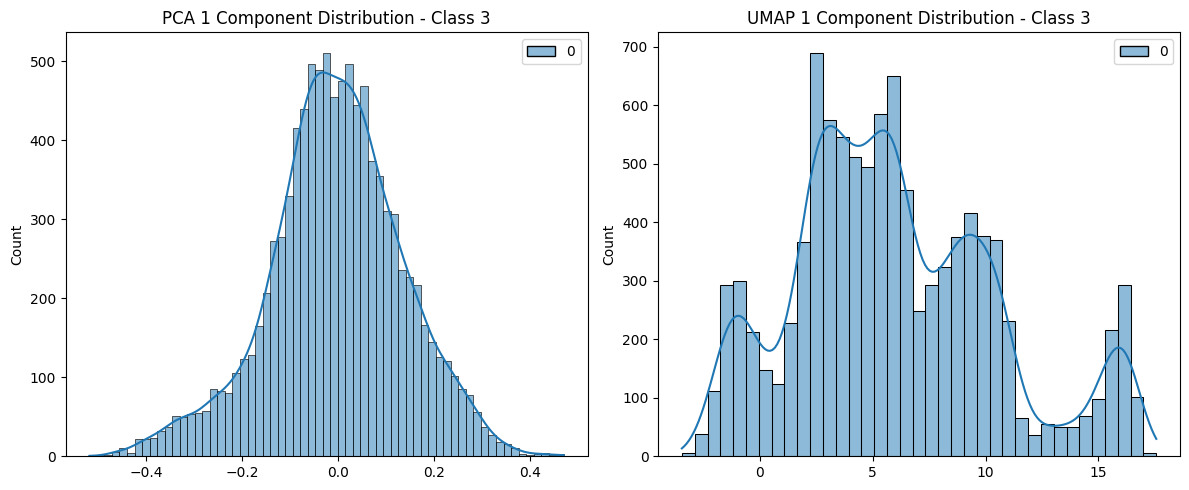

In [12]:
# Iterate over each class and perform normality test on PCA and UMAP embeddings
normality_results = []

for class_label in np.unique(df['class']):
    # Extract the embeddings corresponding to the current class
    pca_class_embs = pca_one_comp_embs[df['class'] == class_label]
    umap_class_embs = umap_one_comp_embs[df['class'] == class_label]
    
    # Perform Lilliefors test (a variant of the Kolmogorov-Smirnov test)
    pca_lilliefors_stat, pca_lilliefors_pval = lilliefors(pca_class_embs)
    umap_lilliefors_stat, umap_lilliefors_pval = lilliefors(umap_class_embs)
    
    # Store the results
    normality_results.append({
        'Class': class_label,
        'PCA_Lilliefors_Statistic': pca_lilliefors_stat,
        'PCA_Lilliefors_PValue': pca_lilliefors_pval,
        'UMAP_Lilliefors_Statistic': umap_lilliefors_stat,
        'UMAP_Lilliefors_PValue': umap_lilliefors_pval
    })

# Convert results to a DataFrame for easier viewing
normality_results_df = pd.DataFrame(normality_results)
print(normality_results_df)

# Optional: Plot the distributions for visual inspection
for class_label in np.unique(df['class']):
    plt.figure(figsize=(12, 5))

    # PCA distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(pca_one_comp_embs[df['class'] == class_label], kde=True)
    plt.title(f'PCA 1 Component Distribution - Class {class_label}')
    
    # UMAP distribution plot
    plt.subplot(1, 2, 2)
    sns.histplot(umap_one_comp_embs[df['class'] == class_label], kde=True)
    plt.title(f'UMAP 1 Component Distribution - Class {class_label}')
    
    plt.tight_layout()
    plt.show()


In [13]:
import pandas as pd
import numpy as np
import scikit_posthocs as sp

# Combine PCA embeddings into a DataFrame
pca_values = np.concatenate([pca_one_comp_embs[df['class'] == label] for label in np.unique(df['class'])])
pca_labels = np.concatenate([[label] * len(pca_one_comp_embs[df['class'] == label]) for label in np.unique(df['class'])])

# Ensure they are 1-dimensional
pca_values = pca_values.flatten()
pca_labels = pca_labels.flatten()

# Create a DataFrame for Dunn's test
pca_df = pd.DataFrame({
    'Values': pca_values,
    'Class': pca_labels
})

# Perform Dunn's test for PCA embeddings
pca_dunn_results = sp.posthoc_dunn(pca_df, val_col='Values', group_col='Class')

# Combine UMAP embeddings into a DataFrame
umap_values = np.concatenate([umap_one_comp_embs[df['class'] == label] for label in np.unique(df['class'])])
umap_labels = np.concatenate([[label] * len(umap_one_comp_embs[df['class'] == label]) for label in np.unique(df['class'])])

# Ensure they are 1-dimensional
umap_values = umap_values.flatten()
umap_labels = umap_labels.flatten()

# Create a DataFrame for Dunn's test
umap_df = pd.DataFrame({
    'Values': umap_values,
    'Class': umap_labels
})

# Perform Dunn's test for UMAP embeddings
umap_dunn_results = sp.posthoc_dunn(umap_df, val_col='Values', group_col='Class')

# Print Dunn's test results
print('Dunn\'s Test Results for PCA Embeddings:')
print(pca_dunn_results)

print('Dunn\'s Test Results for UMAP Embeddings:')
print(umap_dunn_results)


Dunn's Test Results for PCA Embeddings:
               0    1              2              3
0   1.000000e+00  0.0   2.724139e-46  1.623998e-215
1   0.000000e+00  1.0   0.000000e+00   0.000000e+00
2   2.724139e-46  0.0   1.000000e+00  1.364426e-140
3  1.623998e-215  0.0  1.364426e-140   1.000000e+00
Dunn's Test Results for UMAP Embeddings:
               0              1             2              3
0   1.000000e+00   0.000000e+00  0.000000e+00  9.350623e-301
1   0.000000e+00   1.000000e+00  0.000000e+00  3.145153e-261
2   0.000000e+00   0.000000e+00  1.000000e+00   6.719133e-63
3  9.350623e-301  3.145153e-261  6.719133e-63   1.000000e+00


PCA Dunn's Test Heatmap:


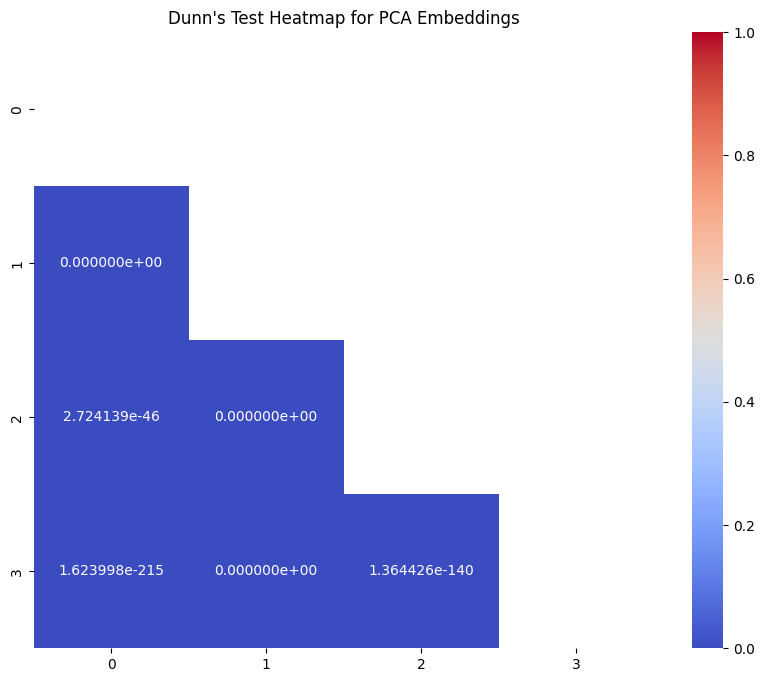

UMAP Dunn's Test Heatmap:


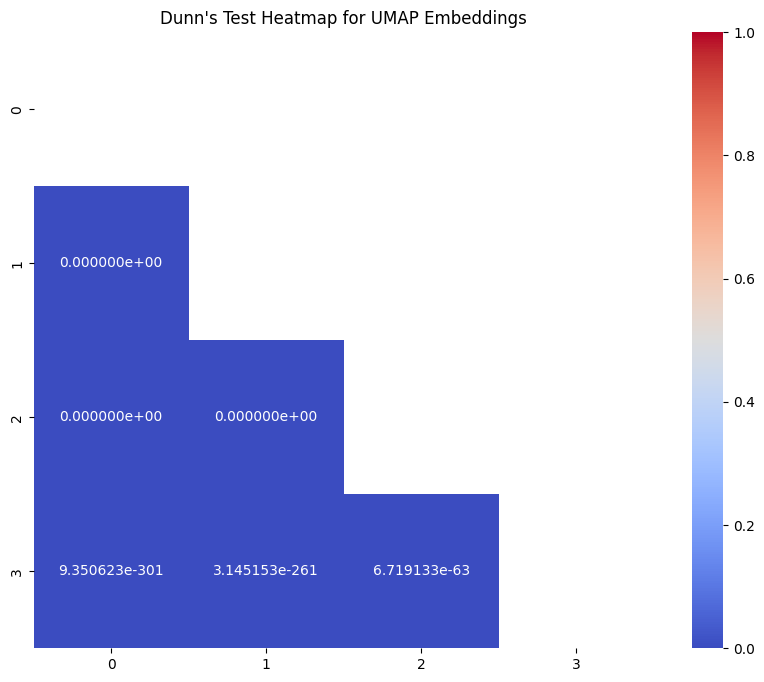

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming pca_dunn_results and umap_dunn_results are DataFrames from Dunn's test
# Here's how you can create heatmaps with the results

def plot_heatmap(df, title):
    plt.figure(figsize=(10, 8))
    
    # Create a mask for the upper triangle (optional, for better visualization)
    mask = np.triu(np.ones_like(df, dtype=bool))

    sns.heatmap(df, annot=True, fmt=".6e", mask=mask, cmap="coolwarm", vmin=0, vmax=1)
    
    plt.title(title)
    plt.show()

# Plot heatmap for PCA Dunn's test results
print('PCA Dunn\'s Test Heatmap:')
plot_heatmap(pca_dunn_results, 'Dunn\'s Test Heatmap for PCA Embeddings')

# Plot heatmap for UMAP Dunn's test results
print('UMAP Dunn\'s Test Heatmap:')
plot_heatmap(umap_dunn_results, 'Dunn\'s Test Heatmap for UMAP Embeddings')